# Import

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Utils

In [4]:
def tensor_to_image(tensor):
    """
    Converts a tensor to an image
    :param tensor: tensor with a shape (batch, height, width, layer)
    :return: image: first image from the tensor
    """

    image = tensor[0].numpy()
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype('uint8')
    return image

def preprocess_image(image, model=None):
    """
    Preprocesses a given image to use with Inception model

    :param image: image to preprocess, numpy array
    :param model: name of the wanted preprocessing, string
    :return:
        - image: the preprocessed image
    """
    image = tf.cast(image, dtype=tf.float32)

    if model == 'inception':
        image = (image / 127.5) - 1.0
    elif model == 'vgg19':
        image = tf.keras.applications.vgg19.preprocess_input(image)
    else:
        image = image / 255.

    return image

def display(image_tensor):
    """
    Display an image
    :param image_tensor: tensor containing an image
    """
    display_image = tensor_to_image(image_tensor)
    plt.figure()
    plt.imshow(display_image)
    plt.show()

# Load images

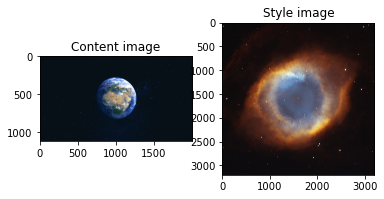

In [11]:
content_image = plt.imread('terre2.jpg')
style_image = plt.imread('images_style/lyre.jpg')

plt.subplot(121)
plt.imshow(content_image)
plt.title('Content image')
plt.subplot(122)
plt.imshow(style_image)
plt.title('Style image')

content_image = tf.image.resize(content_image, (512, 512))
content_image = tf.expand_dims(content_image, 0)
content_image = tf.cast(content_image, tf.uint8)
style_image = tf.image.resize(style_image, (512, 512))
style_image = tf.expand_dims(style_image, 0)
style_image = tf.cast(style_image, tf.uint8)


# Build Model

In [12]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

In [13]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

In [25]:
selected_model_name = 'vgg19'
nb_style_layers = len(style_layers)
selected_model = vgg_model(output_layers)

# Define losses
* style loss
* content loss
* total loss (combination of style and content loss)

In [15]:
def get_style_loss(reality, expectation):
    """Expects two images of dimension h, w, c

    :param reality: tensor with shape: (height, width, channels)
    :param expectation: tensor with shape: (height, width, channels)

    :return style_loss: style loss, scalar
    """
    # get the average of the squared errors
    style_loss = tf.reduce_mean(tf.square(reality - expectation))

    return style_loss

In [16]:
def get_content_loss(reality, expectation):
    """Expects two images of dimension h, w, c

    :param reality: tensor with shape: (height, width, channels)
    :param expectation: tensor with shape: (height, width, channels)

    :return content_loss: content loss, scalar
    """
    # get the sum of the squared error multiplied by a scaling factor
    content_loss = 0.5 * tf.reduce_sum(tf.square(reality - expectation))

    return content_loss

In [17]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
    """ Combine the style and content loss

    :param style_targets: style features of the style image
    :param style_outputs: style features of the generated image
    :param content_targets: content features of the content image
    :param content_outputs: content features of the generated image
    :param style_weight: weight given to the style loss
    :param content_weight: weight given to the content loss

    :return total_loss: the combined style and content loss

    """

    # Sum of the style losses
    style_loss = tf.add_n([get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

    # Sum up the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                             for content_output, content_target in zip(content_outputs, content_targets)])

    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss = style_loss * style_weight / len(style_outputs)

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * content_weight / len(content_outputs)

    # sum up the style and content losses
    total_loss = style_loss + content_loss

    # return the total loss
    return total_loss

# Get features
* style feature
* content feature
* Gram matrix

In [18]:
def gram_matrix(input_tensor):
    """ Calculates the gram matrix and divides by the number of locations

    :param input_tensor: tensor of shape (batch, height, width, channels)

    :return scaled_gram: gram matrix divided by the number of locations
    """

    # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor)
    height = input_shape[1]
    width = input_shape[2]

    # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

    # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations

    return scaled_gram


In [19]:
def get_style_image_features(image):
    """Get the style image features

    :param image: an input image
    :return gram_style_features: the style features as gram matrices
    """
    global selected_model, nb_style_layers

    # preprocess the image using the given preprocessing function
    preprocessed_style_image = preprocess_image(image, selected_model_name)

    # get the outputs from the inception model that you created using inception_model()
    outputs = selected_model(preprocessed_style_image)

    # Get just the style feature layers (exclude the content layer)
    style_outputs = outputs[:nb_style_layers]

    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [gram_matrix(style_output) for style_output in style_outputs]

    return gram_style_features

In [20]:
def get_content_image_features(image):
    """ Get the content image features

    :param image: an input image
    :return content_outputs: the content features of the image
    """
    global selected_model

    # preprocess the image
    preprocessed_content_image = preprocess_image(image, selected_model_name)

    # get the outputs from the inception model
    outputs = selected_model(preprocessed_content_image)

    # get the content layer of the outputs
    content_outputs = outputs[nb_style_layers:]

    return content_outputs

# Learning
* Compute gradients
* Update data

In [21]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight):
    """ Calculate the gradients of the loss with respect to the generated image

    :param image: generated image
    :param style_targets: style features of the style image
    :param content_targets: content features of the content image
    :param style_weight: weight given to the style loss
    :param content_weight: weight given to the content loss
    :param var_weight: weight given to the total variation loss

    :return gradients: gradients of the loss with respect to the input image
    """

    with tf.GradientTape() as tape:
        # get the style image features
        style_features = get_style_image_features(image)

        # get the content image features
        content_features = get_content_image_features(image)

        # get the style and content loss
        loss = get_style_content_loss(style_targets, style_features,
                                      content_targets, content_features,
                                      style_weight, content_weight)

        # add the total variation loss
        loss += var_weight * tf.image.total_variation(image)

    # calculate gradients of loss with respect to the image
    gradients = tape.gradient(loss, image)

    return gradients

In [22]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, var_weight, optimizer):
    """
    Update an image with a specified style

    :param image: generated image
    :param style_targets: style features of the style image
    :param content_targets: content features of the content image
    :param style_weight: weight given to the style loss
    :param var_weight: weight given to the total variation loss
    :param content_weight: weight given to the content loss
    :param optimizer: optimizer for updating the input image
    """

    # Calculate gradients using the function that you just defined.
    gradients = calculate_gradients(image,
                                    style_targets, content_targets,
                                    style_weight, content_weight,
                                    var_weight)

    # apply the gradients to the given image
    optimizer.apply_gradients([(gradients, image)])

# Fitting

In [23]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
    """
    Performs neural style transfer.
    :param style_image: image to get style features from
    :param content_image: image to stylize
    :param style_weight: weight given to the style loss
    :param content_weight: weight given to the content loss
    :param var_weight: weight given to the total variation loss
    :param optimizer: optimizer for updating the input image
    :param epochs: number of epochs
    :param steps_per_epoch = steps per epoch

    :return generated_image: generated image at final epoch
    :return images: collection of generated images per epoch
    """

    updated_images = []
    step = 0

    # get the style image features
    style_targets = get_style_image_features(style_image)

    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image)

    # collect the image updates starting from the content image
    updated_images.append(content_image)

    for i_epoch in range(epochs):
        for i_step_per_epoch in range(steps_per_epoch):
            step += 1

            # Update the image with the style using the function that you defined
            update_image_with_style(image=generated_image,
                                    style_targets=style_targets, content_targets=content_targets,
                                    style_weight=style_weight, content_weight=content_weight,
                                    var_weight=var_weight, optimizer=optimizer)

            print(".", end='')
            if (i_step_per_epoch + 1) % 10 == 0:
                updated_images.append(generated_image)

        # display the current stylized image
        display(generated_image)

        # append to the image collection for visualization later
        updated_images.append(generated_image)
        print("Train step: {}".format(step))

    # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, updated_images

# Try

..................................................

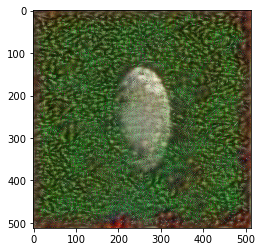

Train step: 50
............

KeyboardInterrupt: 

In [26]:
# define style and content weight
style_weight = 1
content_weight = 1e-5
var_weight = 1e-2

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=30.0, decay_steps=100, decay_rate=0.90
    )
)
# adam = tf.optimizers.Adam(learning_rate=30, beta_1=0.99, epsilon=1e-1)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=var_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=50)


In [27]:
display(stylized_image)

NameError: name 'stylized_image' is not defined